#### Pacotes

In [49]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import warnings

from pathlib import Path
import pickle
warnings.filterwarnings('ignore')

# Importando libs de plots
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
sns.set_style('darkgrid')
# sns.set_context('talk')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [50]:
df_o = pd.read_csv('../Case - End-to-end Machine Learning/Data/olist_orders_dataset.csv', parse_dates = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',	'order_delivered_customer_date',	'order_estimated_delivery_date'])
df_oi = pd.read_csv('../Case - End-to-end Machine Learning/Data/olist_order_items_dataset.csv', parse_dates = ['shipping_limit_date'])
df_op = pd.read_csv('../Case - End-to-end Machine Learning/Data/olist_order_payments_dataset.csv')
df_or = pd.read_csv('../Case - End-to-end Machine Learning/Data/olist_order_reviews_dataset.csv')
df_p = pd.read_csv('../Case - End-to-end Machine Learning/Data/olist_products_dataset.csv')
df_s = pd.read_csv('../Case - End-to-end Machine Learning/Data/olist_sellers_dataset.csv')
df_c = pd.read_csv('../Case - End-to-end Machine Learning/Data/olist_customers_dataset.csv')
df_l = pd.read_csv('../Case - End-to-end Machine Learning/Data/olist_geolocation_dataset.csv')
df_pc = pd.read_csv('../Case - End-to-end Machine Learning/Data/product_category_name_translation.csv')

In [51]:
df_l_grouped = df_l.groupby('geolocation_zip_code_prefix')[['geolocation_lat',	'geolocation_lng'	]].mean().reset_index()

In [52]:
df_o = pd.merge(left = df_o, right = df_c, on = ['customer_id'], how = 'left')
df_o = pd.merge(left = df_o, right = df_op.groupby('order_id')['payment_value'].sum(), on = ['order_id'], how = 'left')
df_o = pd.merge(left = df_o, right = df_or.groupby('order_id')['review_score'].mean().reset_index(), 
                on = ['order_id'], 
                how = 'left')
df_o = pd.merge(left = df_o, 
                right = df_l_grouped.rename(columns = {'geolocation_lat' : 'c_lat',	'geolocation_lng' : 'c_lng'}), 
                left_on = 'customer_zip_code_prefix',
                right_on = 'geolocation_zip_code_prefix',
                how = 'left')

df_oi = pd.merge(left = df_oi, right = df_p, on = ['product_id'], how = 'left')
df_oi = pd.merge(left = df_oi, right = df_s, on = ['seller_id'], how = 'left')
df_oi = pd.merge(left = df_oi, 
                 right = df_l_grouped.rename(columns = {'geolocation_lat' : 's_lat',	'geolocation_lng' : 's_lng'}),
                 left_on = 'seller_zip_code_prefix',
                 right_on = 'geolocation_zip_code_prefix', 
                 how = 'left')

In [53]:
df_oi.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'geolocation_zip_code_prefix', 's_lat', 's_lng'],
      dtype='object')

#### Feature Engineering Inicial
#### Construindo algumas features que fazem sentido com o problema

In [54]:
df_oi = pd.merge(left = df_oi, right = df_o, on = ['order_id'], how = 'left')

In [55]:
import geopy.distance

def calculate_distance(data):
  try:
    return geopy.distance.geodesic((data['c_lat'], data['c_lng']), (data['s_lat'], data['s_lng'])).km
  except:
    return 0

df_oi['customer_seller_distance'] = df_oi.apply(calculate_distance, axis = 1)

(array([8.9846e+04, 1.4450e+04, 7.6220e+03, 7.2400e+02, 4.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0.        ,  865.21197221, 1730.42394441, 2595.63591662,
        3460.84788882, 4326.05986103, 5191.27183323, 6056.48380544,
        6921.69577764, 7786.90774985, 8652.11972205]),
 <BarContainer object of 10 artists>)

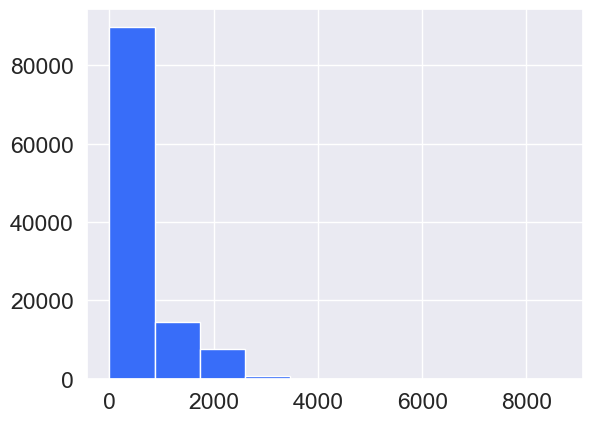

In [56]:
plt.hist(df_oi['customer_seller_distance'])

In [57]:
df_oi['product_category_name'].fillna('unknown', inplace = True)

In [58]:
df_oi_s = df_oi.groupby('seller_id').agg({'price' : 'sum', 'order_item_id' : 'count'}).reset_index().rename(columns = {'price' : 's_total_volume', 'order_item_id' : 's_total_items'})

In [59]:
df_oi['product_volume'] = df_oi[['product_length_cm',	'product_height_cm','product_width_cm']].prod(axis =1)

In [60]:
df_oi = pd.merge(left = df_oi, right = df_oi_s, on = 'seller_id', how = 'left')

In [61]:
df_o['logistics_length'] = (df_o['order_delivered_customer_date'] - df_o['order_approved_at']).dt.days
df_o['delay_length'] = (df_o['order_delivered_customer_date'] - df_o['order_estimated_delivery_date']).dt.days
df_o['is_delayed'] = df_o['delay_length'] > 0

In [62]:
df_oi_g = df_oi.groupby('order_id').agg({'customer_seller_distance' : 'max',
                               'product_volume' : 'sum',
                               'product_weight_g' : 'sum',
                               'product_photos_qty' : 'sum',
                               'freight_value' : 'sum',
                               'order_item_id' : 'count',
                               'shipping_limit_date' : 'min',
                               'product_category_name' : lambda x: x.mode()[0],
                               'seller_state' : lambda x: x.mode()[0],
                               's_total_volume' : 'mean',
                               's_total_items' : 'mean',
                              }).reset_index()

In [63]:
df_o = pd.merge(left = df_o, right = df_oi_g, on = ['order_id'], how = 'left')

In [64]:
df_o['freight_ratio'] = df_o['freight_value'] / df_o['payment_value']

In [65]:
df_o.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'payment_value', 'review_score',
       'geolocation_zip_code_prefix', 'c_lat', 'c_lng', 'logistics_length',
       'delay_length', 'is_delayed', 'customer_seller_distance',
       'product_volume', 'product_weight_g', 'product_photos_qty',
       'freight_value', 'order_item_id', 'shipping_limit_date',
       'product_category_name', 'seller_state', 's_total_volume',
       's_total_items', 'freight_ratio'],
      dtype='object')

In [66]:
df_o.describe()

,customer_zip_code_prefix,payment_value,review_score,geolocation_zip_code_prefix,c_lat,c_lng,logistics_length,delay_length,customer_seller_distance,product_volume,product_weight_g,product_photos_qty,freight_value,order_item_id,s_total_volume,s_total_items,freight_ratio
count,99441.000000,99440.000000,98673.000000,99163.000000,99163.000000,99163.000000,96462.000000,96476.000000,98666.000000,9.866600e+04,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98665.000000
mean,35137.474583,160.990267,4.086793,35057.887176,-21.191224,-46.175442,11.642968,-11.876881,598.841489,1.740143e+04,2390.027669,2.486997,22.823562,1.141731,40695.499919,422.221620,0.208755
std,29797.938996,221.951257,1.346274,29784.314664,5.608637,4.056067,9.520747,10.183854,593.460201,3.040217e+04,4773.239825,2.233566,21.650909,0.538452,55132.011436,555.505352,0.125721
min,1003.000000,0.000000,1.000000,1003.000000,-33.689948,-72.668881,-7.000000,-147.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000,3.500000,1.000000,0.000000
25%,11347.000000,62.010000,4.000000,11320.000000,-23.589378,-48.097950,6.000000,-17.000000,179.924587,2.964000e+03,300.000000,1.000000,13.850000,1.000000,5042.550000,57.000000,0.116502
50%,24416.000000,105.290000,5.000000,24350.000000,-22.924970,-46.630647,9.000000,-12.000000,432.234602,7.260000e+03,750.000000,2.000000,17.170000,1.000000,14362.300000,173.000000,0.183256
75%,58900.000000,176.970000,5.000000,58406.500000,-20.139828,-43.598897,15.000000,-7.000000,797.068732,1.987200e+04,2066.750000,3.000000,24.040000,1.000000,46610.400000,522.000000,0.275422
max,99990.000000,13664.080000,5.000000,99990.000000,42.184003,-8.723762,208.000000,188.000000,8652.119722,1.476000e+06,184400.000000,62.000000,1794.960000,21.000000,229472.630000,2033.000000,0.955451


In [67]:
df_o['target'] = np.where(df_o['review_score'] < 5, '0', '1').astype(int)

In [68]:
df_o['target'] 

0        0
1        0
2        1
3        1
4        1
        ..
99436    1
99437    0
99438    1
99439    0
99440    1
Name: target, Length: 99441, dtype: int32

In [69]:
df_o['target'].value_counts()

1    57723
0    41718
Name: target, dtype: int64

In [70]:
df_o.drop(columns = ['review_score'], inplace = True)

In [71]:
df_o['customer_state'] = df_o['customer_state'].map({'SP': 'SP',
                      'BA': 'BA',
                      'GO': 'GO',
                      'RN': 'NE',
                      'PR': 'PR',
                      'RS': 'RS',
                      'RJ': 'RJ',
                      'MG': 'MG',
                      'SC': 'SC',
                      'RR': 'N',
                      'PE': 'PE',
                      'TO': 'N',
                      'CE': 'CE',
                      'DF': 'DF',
                      'SE': 'NE',
                      'MT': 'CO',
                      'PB': 'NE',
                      'PA': 'N',
                      'RO': 'N',
                      'ES': 'ES',
                      'AP': 'N',
                      'MS': 'CO',
                      'MA': 'NE',
                      'PI': 'NE',
                      'AL': 'NE',
                      'AC': 'N',
                      'AM': 'N'})

df_o['seller_state'] = df_o['seller_state'].map({'SP': 'SP',
                      'BA': 'BA',
                      'GO': 'GO',
                      'RN': 'NE',
                      'PR': 'PR',
                      'RS': 'RS',
                      'RJ': 'RJ',
                      'MG': 'MG',
                      'SC': 'SC',
                      'RR': 'N',
                      'PE': 'PE',
                      'TO': 'N',
                      'CE': 'CE',
                      'DF': 'DF',
                      'SE': 'NE',
                      'MT': 'CO',
                      'PB': 'NE',
                      'PA': 'N',
                      'RO': 'N',
                      'ES': 'ES',
                      'AP': 'N',
                      'MS': 'CO',
                      'MA': 'NE',
                      'PI': 'NE',
                      'AL': 'NE',
                      'AC': 'N',
                      'AM': 'N'})